# Poly(2-Ethyl-2-oxazoline) - API in water

## Import modules

In [1]:
from sys import stdout
import time
import requests 
from openbabel import openbabel,pybel
from simtk.openmm import app
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
#from openforcefield import *
from openforcefield.topology import Molecule, Topology
from openforcefield.utils.toolkits import OpenEyeToolkitWrapper
import openforcefield
import openforcefields
import openforcefield.utils
from openforcefield.typing.engines.smirnoff import ForceField
from openmmforcefields.generators import SystemGenerator
from openmmforcefields.generators import SMIRNOFFTemplateGenerator
from openmoltools import packmol
import numpy as np
import nglview
import ipywidgets
import mdtraj as md
import parmed as pmd
import matplotlib.pyplot as plt
import pandas as pd
from openeye import oechem
import tempfile

_ColormakerRegistry()

## Parameterize molecules

### Polymer

#### Construction polymer

In [2]:
# SMILES notation
initiator = "C"
unit = "N(C(=O)CC)CC"
terminator = "C"
number_of_units = 10
# do not use more than 10 monomers, see below

polymer = initiator + number_of_units*unit + terminator
polymer_file = pybel.Outputfile('pdb',f"polymer_{number_of_units}units.pdb",overwrite=True)

# Conversion to PDB
mol = pybel.readstring('smi',polymer)
print(mol)
mol.make3D()
polymer_file.write(mol)
polymer_file.close()

print(mol.write('pdb',f"polymer_{number_of_units}units.pdb",overwrite=True))
#from smile to format x codes gen3d option is needed, command line: obabel -i stdin -o out.pdb --gen3d <<< "CC"

CN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCN(C(=O)CC)CCC	

None


#### Visualisation

In [3]:
nglview.show_file(f"polymer_{number_of_units}units.pdb")

NGLWidget()

#### Parametrization

In [78]:
# when imported from an xyz file
'''
polymer_xyz = 'eth5oxf.xyz'
polymer_filename = polymer_xyz[:-4]
print(polymer_filename)

#generate sdf file and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
obConversion.SetInAndOutFormats("xyz", "pdb")
mol = openbabel.OBMol()
obConversion.ReadFile(mol, polymer_xyz)

obConversion.WriteFile(mol, f"{polymer_filename}.pdb")
obConversion.SetInAndOutFormats("xyz", "sdf")
obConversion.WriteFile(mol, f"{polymer_filename}.sdf")
'''
# generate sdf file
obConversion = openbabel.OBConversion()
mol = openbabel.OBMol()
obConversion.SetInAndOutFormats("pdb", "sdf")
obConversion.ReadFile(mol,f"polymer_{number_of_units}units.pdb")
obConversion.WriteFile(mol, f"polymer_{number_of_units}units.sdf")

#Forcefield     
off_forcefield = ForceField('openff-1.0.0.offxml')

#parameterization
from openforcefield.topology import Molecule, Topology

'''
polymer = app.PDBFile(f"{polymer_filename}.pdb")
polymer_positions =  polymer.getPositions()
uniq_molecules = [Molecule.from_file(f"{polymer_filename}.sdf")]
'''

polymer = app.PDBFile(f"polymer_{number_of_units}units.pdb")
polymer_positions =  polymer.getPositions()
uniq_molecules = [Molecule.from_file(f"polymer_{number_of_units}units.pdb")]
off_polymer_topology = Topology.from_openmm(polymer.topology,unique_molecules=uniq_molecules)
off_polymer_system = off_forcefield.create_openmm_system(off_polymer_topology)

When more monomer units are used, an error appears. Due to the large number of atoms, openforcefield cannot parameterize all the atoms. 

---> off_polymer_system = off_forcefield.create_openmm_system(off_polymer_topology)

~/anaconda3/envs/myenv/lib/python3.7/site-packages/openforcefield/utils/toolkits.py in compute_partial_charges_am1bcc(self, molecule)
   1271 
   1272         if quacpac_status is False:
-> 1273             raise Exception('Unable to assign charges')
   1274 
   1275         # Extract and return charges

Exception: Unable to assign charges

In the 0.7.0 release in April 2020, this issue will be solved (https://github.com/openforcefield/openforcefield/pull/509). 
To solve this now, two things need to be done. 
1. First the source code of openforcefield/utils/toolkits.py needs to be adapted according to https://github.com/openforcefield/openforcefield/pull/509/files#diff-c854e3299a958176be6dac43c8f3213eR2444-R2448. 
2. A LibraryCharges file needs to be created to assign the charges. It will be added to line off_forcefield = ForceField('openff-1.0.0.offxml') as an extra argument. The polymer is split up in unique parts and the charges are assigned manually. Analogue to https://github.com/openforcefield/openforcefield/blob/e03091dd9e063675707c64f9538cd715ecfb7ccb/openforcefield/tests/test_forcefield.py#L170-L178

##### Energy minimization

In [79]:
integrator = VerletIntegrator(1.0 * femtoseconds)
#numerical method to integrate Newton's equations of motion
context = Context(off_polymer_system, integrator)
#Context stores the complete state of a simulation: time, position particle, velocity particle
#OpenMM context class reference
#Context(self,system,integrator,platform,mapstringstring properties)
polymer_positions =  polymer.getPositions()
context.setPositions(polymer_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

Original energy: 1180.7895358079163 kJ/mol


### API

#### Construction

In [80]:
# API
api_cid = ['35802']

#generate sdf file and transform them to pdb using openbabel
obConversion = openbabel.OBConversion()
#OBConversion transforms molecule classes
obConversion.SetInAndOutFormats("sdf", "pdb")
mol = openbabel.OBMol()
#OBMol most important molecule class

for cid in api_cid:
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/{cid}/record/SDF/?record_type=3d&response_type=save"
    with open(f"API_{cid}.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"API_{cid}.sdf")
    obConversion.WriteFile(mol, f"API_{cid}.pdb")

#### Visualisation

In [81]:
nglview.show_file(f"API_{api_cid[0]}.pdb")

NGLWidget()

#### Parametrization

In [8]:
#Forcefield     
off_forcefield = ForceField('openff-1.0.0.offxml')

for cid in api_cid :
    uniq_molecules = [Molecule.from_file(f"API_{cid}.sdf")]
    api_pdb = PDBFile(f"API_{cid}.pdb")
    api_positions =  api_pdb.getPositions()
    off_api_topology = Topology.from_openmm(api_pdb.topology,unique_molecules=uniq_molecules)
    off_api_system = off_forcefield.create_openmm_system(off_api_topology)

/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3  O   UNL     1       6.202   1.839   0.002  1.00  0.00           O  , HETATM    2  O   UNL     1      -3.211  -2.659   0.001  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    4  O   UNL     1       5.839  -0.416  -0.001  1.00  0.00           O  , HETATM    3  O   UNL     1       6.202   1.839   0.002  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

##### Energy minimization

In [9]:
integrator = VerletIntegrator(1.0 * femtoseconds)
#numerical method to integrate Newton's equations of motion
context = Context(off_api_system, integrator)
#Context stores the complete state of a simulation: time, position particle, velocity particle
#OpenMM context class reference
#Context(self,system,integrator,platform,mapstringstring properties)
context.setPositions(api_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

Original energy: 322.4397266369872 kJ/mol


## Generate all necessary input

## AmberTools

Alternatively to the OpenFF approach, AmberTools could be used for generating the forcefield.
One can however look at OpenFF as a clean and user-friendly approach of gaff (generalized amber forcefield) this is hence a prefered way to parameterize everything.

https://ambermd.org/tutorials/advanced/tutorial27/pet.html



## OpenFF
TODO ADD some explanations

#### Polymer parameterized by 3 different Units? 
TODO   https://github.com/openforcefield/open-forcefield-tools/blob/master/examples/substructure_linking.ipynb

### Polymer-water solvent box

Multiple approaches are available to constuct a solvent box:
1. Packmol (openmoltools)
2. OpenMM modeller (https://github.com/openmm/openmmforcefields)
3. leap (Ambertools)
4. openforcefield-tools (Property calculation toolkit requires OpenEye licence) https://github.com/openforcefield/openforcefield/issues/66
https://github.com/slochower/smirnoff-host-guest/blob/3a319972d5b6fded1784eaad75d6bf5e754343a3/mol2-to-prmtop.ipynb;https://github.com/MobleyLab/SolvationToolkit

Packmol should be installed; openmoltools;mdtraj (openeye)
git clone https://github.com/MobleyLab/SolvationToolkit.git
cd SolvationToolkit
pip install .

We opt to use the easiest approach here which is the direct use of openMM to solvate the molecule
which requires a small trick namely and converting the OpenMM System to a ParmEd Structure for which we will be able to mix the protein with water.
https://github.com/openforcefield/openforcefield/blob/master/examples/using_smirnoff_with_amber_protein_forcefield/toluene_in_T4_lysozyme.ipynb
https://github.com/openforcefield/openforcefield/blob/master/examples/using_smirnoff_in_amber_or_gromacs/convert_to_amber_gromacs.ipynb

Multiple methods are feasible for an initial estimation of the box size, the one shown here is fairly easy.

In [10]:
# determine solvent box size
# model polymer as one long chain with two solvent layers of water around it 
# the solvated chain part is a cilinder
l_poly = 40 #A, for 50 monomers 
# length of 10mer is about sqrt(2)*100 A
n_shells = 2 #standard for water
r_solvlayer = 2.5 #A, standard for water
l_solute = l_poly # neglect solvation of the chain ends + 2*n_shells*r_solvlayer
l_box = l_solute + 2*2 #buffer of 2A
print('l_box=',l_box)
d_poly = 20 #A, for this polymer
h_box = d_poly + 2*(n_shells*r_solvlayer+2) # solvation around chain, buffer of 2A
print('h_box=',h_box)
V_box = l_box*(h_box**2)
print('V_box=',V_box)

V_solute = np.pi*((d_poly/2+n_shells*r_solvlayer)**2)*l_poly #neglect solvation at the chain ends
print('V_solute=',V_solute)
#rint('fraction solute
V_solvent = V_box-V_solute #A³
print('V_solvent=',V_solvent)
print('frac V_solvent/V_box=',V_solvent/V_box)
rho_solvent = 10**(-24) #g/A³
m_solvent = V_solvent*rho_solvent #g
MM_solvent = 18 #g/mol
N_a = 6.22*10**(23) #particles/mol
n_solvent = m_solvent/MM_solvent*N_a
#naar atomaire eenheden
print(n_solvent)

l_box= 44
h_box= 34.0
V_box= 50864.0
V_solute= 28274.333882308136
V_solvent= 22589.666117691864
frac V_solvent/V_box= 0.4441189469505321
780.5984625113522


In [82]:
# Create water box with openmoltools

water_smiles = 'O'
number_of_units = 10

obConversion = openbabel.OBConversion()
mol = openbabel.OBMol()


if not os.path.isfile('water.pdb'):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/962/record/SDF/?record_type=3d&response_type=save"
    with open(f"water.sdf", "w") as f:
        f.write(requests.get(url).text)
    obConversion.ReadFile(mol, f"water.sdf")
    obConversion.WriteFile(mol, f"water.pdb")
    
md_traj_water = md.load("water.pdb")
if packmol.standardize_water(md_traj_water):
    print('Water molecule already had correct format')
else: print('The water_pdbFile should be adjusted: 3 atoms 1 residue, ADJUST_MANUALY')
print(md_traj_water)

initiator = "C"
unit = "N(C(=O)CC)CC"
terminator = "C"
number_of_units = 10
polymer_smiles = initiator + number_of_units*unit + terminator

packmol.rename_water_atoms('water.pdb')

pdb_filenames = [f"polymer_{number_of_units}units.pdb" , "water.pdb"]

n_molecules = [1,int(n_solvent)+1000] 

if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([polymer_smiles,water_smiles],n_molecules)
    print('volume density calculation is performed')
    print(box_size)
else:
    box_size = 600.0

## create box with corresponding md_traj trajectory and topology 
#manual adjusted pack_box method, alternatively, generate this file your self. Caution with the formats!
#This packmol implementation has a fixed packom input file format, restricting the flexible use of packmol.. 
#I believe it is best to use the input files generated above and make a packmol file yourself and hence run it yourself instead of using this python interface.
#md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,h_box,h_box,l_box,True,rot_x,rot_y,rot_z)
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)

#906 seconds for 50-mer with 4500 water mol in a box of 19x19x702
#1220.56384 seconds for 50-mer with 2000 water mol in a box of 19x19x304

md_traj_trajectory.save_pdb(f'polymer_{number_of_units}units_N{n_molecules[1]}_size{box_size}_openmoltools.pdb',force_overwrite=True)

Water molecule already had correct format
<mdtraj.Trajectory with 1 frames, 3 atoms, 1 residues, without unitcells>
volume density calculation is performed
43.93343711569201

# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp286mngmn/tmp5drqf9pq.pdb
add_amber_ter


structure polymer_10units.pdb
  number 1
  inside box 0. 0. 0. 41.933437 41.933437 41.933437
end structure

structure water.pdb
  number 2073
  inside box 0. 0. 0. 41.933437 41.933437 41.933437
end structure



##### Visualize the molecule

In [83]:
#t = md.load(f'{polymer_filename}_N{n_molecules[1]}_openmoltools.pdb')
#f"polymer_{number_of_units}units.pdb"
t = md.load(f'polymer_{number_of_units}units_N{n_molecules[1]}_size{box_size}_openmoltools.pdb')
w = nglview.show_mdtraj(t)
#nglview.show_file(f'polymer_{number_of_units}units_N{n_molecules[1]}_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
w.add_representation('ball+stick',selection='water')
#w.add_representation('axes')
w

#VMD gives better representation, nglview sometimes fails


NGLWidget()

#### Parameterize solvent box

To use a barostat, you need to define a barostat whose parameters will be copied into each system (with a different random number seed):
        >>> pressure = 1.0 * unit.atmospheres
        >>> temperature = 298.0 * unit.kelvin
        >>> frequency = 25 # steps
        >>> system_generator.barostat = openmm.MonteCarloBarostat(pressure, temperature, frequency)

In [90]:
# MD Setting 

timestep = 2*femtoseconds #in femtoseconds
total_simulation_steps = 10000
temperature = 298*kelvin #in K 
pressure = 1*bar #in bar, for an isobaric simulation
frequency = 25 # steps

In [86]:
ff_small_molecule = 'openff-1.2.1'
ff_water = 'tip3pfb'


monomer_names=[f"polymer_{number_of_units}units.pdb",'water.pdb']
molecules = [Molecule.from_file(name) for name in monomer_names] #RDkit and OEChem do not support same file formats!!
generator = SystemGenerator(forcefields = [f'{ff_water}.xml'],small_molecule_forcefield=ff_small_molecule,molecules = molecules)

solvated_structure = PDBFile(f'polymer_{number_of_units}units_N{n_molecules[1]}_size{box_size}_openmoltools.pdb')
openmm_topology = solvated_structure.topology

#Not sure if this is still important in the new versions
generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)

system =  generator.create_system(openmm_topology)

#### Alternative approach
TODO test if generator should contain barostat or it can be added afterwards

In [33]:
ff_small_molecule = 'openff-1.2.1'
ff_water = 'tip3pfb'
monomer_names=[f"polymer_{number_of_units}units.pdb"]
molecules = [Molecule.from_file(name) for name in monomer_names] #RDkit and OEChem do not support same file formats!!
generator = SystemGenerator(forcefields = [f'{ff_water}.xml'],small_molecule_forcefield=ff_small_molecule,molecules = molecules)

polymer_structure = PDBFile(f"polymer_{number_of_units}units.pdb") #or polymer_api structure
openmm_topology = polymer_structure.topology

#system =  generator.create_system(openmm_topology)
#generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)

modeller = app.Modeller(polymer_structure.topology,polymer_structure.positions)
modeller.addSolvent(generator.forcefield,padding=5.0*angstroms)
system = generator.create_system(modeller.topology)

#Barostat
#Potentially this has to be added to the generator
system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  
with open('solvated_polymer.pdb','w') as outfile:
    app.PDBFile.writeFile(modeller.topology,modeller.positions,outfile)

In [35]:
xml_file = XmlSerializer.serializeSystem(system)
#print(xml_file)
with open(f'solvated_polymer.xml','w') as xmlfile:
    xmlfile.write(
        xml_file
    )

##### Energy 

In [88]:
integrator = VerletIntegrator(1.0 * femtoseconds)
#context = Context(omm_box_system, integrator)
context = Context(system, integrator)
context.setPositions(solvated_structure.positions)
#context.setPositions(modeller.positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

Original energy: 87259.83550586298 kJ/mol


In [91]:
#Thermostat
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)

#setting up the simulation

#depending on which approach is used
pdb_box = solvated_structure
#pdb_box = PDBFile('solvated_polymer.pdb')

simulation = Simulation(pdb_box.topology, system, integrator)
box_positions = pdb_box.getPositions()
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open("initial_box.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(DCDReporter(f'traj_polymer_{number_of_units}units_N{n_molecules[1]}_size{h_box}x{h_box}x{l_box}.dcd', 100))
simulation.reporters.append(StateDataReporter(stdout, 10000, step=True,
                                              temperature=True,volume=True,density=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(f"scalars_polymer_{number_of_units}units_N{n_molecules[1]}_size{h_box}x{h_box}x{l_box}.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
#"Step","Temperature (K)","Box Volume (nm^3)","Density (g/mL)","Elapsed Time (s)"
10000,296.9306823164456,63.43193675851694,1.0043859055090087,0.00014066696166992188
Elapsed time 341.05 seconds
Done!


In [92]:
import nglview
import ipywidgets

#water is not shown
traj = md.load(f'traj_polymer_{number_of_units}units_N{n_molecules[1]}_size{h_box}x{h_box}x{l_box}.dcd', top='initial_box.pdb')
traj.superpose(traj, 0)
w = nglview.show_mdtraj(traj)
w.add_representation('ball+stick',selection='water')
w


NGLWidget(max_frame=99)

### Molecular dynamics simulation: Polymer-water 

### Polymer-water-api box
Possibly I will need to create the forcefield in a different way, combining both polymer and api forcefield in the system generation.

In [44]:
# model polymer as one long chain with two solvent layers of water around it 
# the solvated chain part is a cilinder
l_poly = 220 #A, for 50 monomers 
n_shells = 2 #standard for water
r_solvlayer = 2.5 #A, standard for water
l_solute = l_poly # neglect solvation of the chain ends + 2*n_shells*r_solvlayer
l_box = l_solute + 2*2 #buffer of 2A
print('l_box=',l_box)
d_poly = 20 #A, for this polymer
h_box = d_poly + 2*(n_shells*r_solvlayer+2) # solvation around chain, buffer of 2A
print('h_box=',h_box)
V_box = l_box*(h_box**2)
print('V_box=',V_box)

V_solute_poly= np.pi*((d_poly/2+n_shells*r_solvlayer)**2)*l_poly #neglect solvation at the chain ends
print('V_solute_poly=',V_solute_poly)
n_API = 10
r_API = 7 #A
V_solute_API = n_API*4/3*np.pi*((r_API+n_shells*r_solvlayer)**3)
print('V_solute_API=',V_solute_API)
V_solute = V_solute_poly + V_solute_API
print('V_solute=',V_solute)
#rint('fraction solute
V_solvent = V_box-V_solute #A³
print('V_solvent=',V_solvent)
print('frac V_solvent/V_box=',V_solvent/V_box)
rho_solvent = 10**(-24) #g/A³
m_solvent = V_solvent*rho_solvent #g
MM_solvent = 18 #g/mol
N_a = 6.22*10**(23) #particles/mol
n_solvent = m_solvent/MM_solvent*N_a
#naar atomaire eenheden
print(n_solvent)

l_box= 224
h_box= 34.0
V_box= 258944.0
V_solute_poly= 155508.83635269475
V_solute_API= 72382.29473870884
V_solute= 227891.1310914036
V_solvent= 31052.8689085964
frac V_solvent/V_box= 0.1199211756541816
1073.0491367303869


In [71]:
#Water molecule
water_smiles = 'O'
number_of_units = 10

md_traj_water = md.load("water.pdb")
if packmol.standardize_water(md_traj_water):
    print('Water molecule already had correct format')
else: print('The water_pdbFile should be adjusted: 3 atoms 1 residue, ADJUST_MANUALY')
print(md_traj_water)

packmol.rename_water_atoms('water.pdb')

Water molecule already had correct format
<mdtraj.Trajectory with 1 frames, 3 atoms, 1 residues, without unitcells>


In [68]:
api_smiles = Molecule.from_file(f"API_{cid}.sdf").to_smiles()
pdb_filenames = [f"polymer_{number_of_units}units.pdb",f"API_{cid}.pdb", "water.pdb"]
cid = 35802

n_molecules = [1,20,8000] 
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([polymer_smiles,api_smiles,water_smiles],n_molecules)
    print(box_size)
else:
    box_size = 40.0

69.42670075340277


In [54]:
h_box = 39
l_box = 224

rot_x = 0
rot_y = 2*np.pi/6
rot_z = 0

# create box with corresponding md_traj trajectory and topology
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,box_size=box_size)#h_box,h_box,l_box,True,rot_x,rot_y,rot_z)
print(md_traj_trajectory.topology)
md_traj_trajectory.save_pdb(f'polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')


# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpzcx34vv5/tmp342f33um.pdb
add_amber_ter


structure polymer_10units.pdb
  number 1
  inside box 0. 0. 0. 67.426701 67.426701 67.426701
end structure

structure API_35802.pdb
  number 20
  inside box 0. 0. 0. 67.426701 67.426701 67.426701
end structure

structure water.pdb
  number 8000
  inside box 0. 0. 0. 67.426701 67.426701 67.426701
end structure

<mdtraj.Topology with 8021 chains, 8021 residues, 24868 atoms, 16907 bonds>


##### Visualize the molecule

In [59]:
t = md.load(f'polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
print(f'polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
w = nglview.show_mdtraj(t)
w.add_representation('ball+stick',selection='water')
w

polymer_10units_20_API_35802_8000water_size39x39x224_openmoltools.pdb


NGLWidget()

#### Parameterize ASD 

To use a barostat, you need to define a barostat whose parameters will be copied into each system (with a different random number seed):
        >>> pressure = 1.0 * unit.atmospheres
        >>> temperature = 298.0 * unit.kelvin
        >>> frequency = 25 # steps
        >>> system_generator.barostat = openmm.MonteCarloBarostat(pressure, temperature, frequency)

In [74]:
# MD Setting 

timestep = 2*femtoseconds #in femtoseconds
total_simulation_steps = 1000
temperature = 298*kelvin #in K 
pressure = 1*bar #in bar, for an isobaric simulation
frequency = 25 # steps

In [72]:
#The forcefield used for the small molecules

#ff_small_molecule = 'openff-1.0.0'
#off_forcefield = ForceField('/home/osboxes/anaconda3/envs/myenv/lib/python3.7/site-packages/openforcefield/typing/engines/smirnoff/openff-1.0.0.offxml')
off_forcefield = ForceField(f'{ff_small_molecule}.offxml')#,'tip3p.offxml') #at the moment tip3pfb is not available... work around via systemgenerator?

#Define all monomers (sdf,smiles or mol format) used in the solvent box, 
#(if a licence for openEye is obtained this can also be other formats are applicable)
monomer_names = [polymer_smiles,api_smiles,water_smiles]
pdb_box = app.PDBFile(f'polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
unique_molecules = [Molecule.from_smiles(name) for name in monomer_names] #with openeye different formats can be used

#BAROSTAT should be added to each component seperately if different forcefields are used

system_generator = SystemGenerator(forcefields=['tip3pfb.xml'], small_molecule_forcefield=f'{ff_small_molecule}')#,forcefield_kwargs=forcefield_kwargs)#, cache='db.json')


system_generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)

box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
off_box_system = off_forcefield.create_openmm_system(off_box_topology)


/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      3  C   UNL A   1      31.956  12.592   2.184  1.00  0.00           C  , ATOM      1  C   UNL A   1      33.497  11.046   0.885  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      5  C   UNL A   1      30.833  11.627   1.966  1.00  0.00           C  , ATOM      3  C   UNL A   1      31.956  12.592   2.184  1.00  0.00           C  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/elias/anaconda3/envs/openmm/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstr

In [73]:
xml_file = XmlSerializer.serializeSystem(off_box_system)
#print(xml_file)
with open(f'xml_polymer_{number_of_units}units_N{n_molecules[1]}_size{h_box}x{h_box}x{l_box}.xml','w') as xmlfile:
    xmlfile.write(
        xml_file
    )

In [75]:

#Thermostat
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)
#for isobaric simulation; I believe this is no longer needed, as it is already included in the omm_box_system.
#off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = app.Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open("initial_box_API_polymer.pdb", "w") as f:
    app.PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(app.DCDReporter(f'traj_polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}.dcd', 100))
simulation.reporters.append(app.StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(app.StateDataReporter("scalars.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

Starting simulation
Elapsed time 118.93 seconds
Done!


In [76]:
#water is not shown
traj = md.load(f'traj_polymer_{number_of_units}units_{n_molecules[1]}_API_{cid}_{n_molecules[2]}water_size{h_box}x{h_box}x{l_box}.dcd', top='initial_box_API_polymer.pdb')
traj.superpose(traj, 0)
w = nglview.show_mdtraj(traj)
w.add_representation('ball+stick',selection='water')
w


NGLWidget(max_frame=9)

### Molecular dynamics simulation: API-water 

#### Create API-water box

In [ ]:
# call pdb files of molecules
api_cid = ['35802']
pdb_filenames = [f"API_{api_cid[0]}.pdb" , "water.pdb"]
api_smiles = Molecule.from_file(f"API_{api_cid[0]}.pdb").to_smiles()
water_smiles = 'O'

# create box with corresponding md_traj trajectory and topology
n_molecules = [30,1800] 
if OpenEyeToolkitWrapper.is_available():
    box_size = packmol.approximate_volume_by_density([api_smiles,water_smiles],n_molecules)
    print('volume density calculation is performed')
    print(box_size)
else:
    box_size = 50.0
print(box_size)
h_box = box_size
l_box = box_size
md_traj_trajectory = packmol.pack_box(pdb_filenames,n_molecules,h_box,h_box,l_box)
md_traj_trajectory.save_pdb(f'{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb',force_overwrite=True)

#### Visualize box

In [ ]:
t2 = md.load(f'{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
w = nglview.show_mdtraj(t2)
w.add_representation('ball+stick',selection='water')
w

#### Parametrize box

In [ ]:
# MD settings
timestep = 2*femtoseconds #in femtoseconds
total_simulation_steps = 100000
temperature = 298*kelvin #in K 
pressure = 1*bar #in bar, for an isobaric simulation
frequency = 25 # steps

In [ ]:
# select force field
ff_small_molecule = 'openff-1.0.0'
ff_water = 'tip3pfb.xml'
off_forcefield = ForceField(f'{ff_small_molecule}.offxml')

water_smiles = 'O'
api_smiles = Molecule.from_file(f"API_{cid}.sdf").to_smiles()
monomer_names = [api_smiles,water_smiles]
pdb_box = PDBFile(f'{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
unique_molecules = [Molecule.from_smiles(name) for name in monomer_names] 

system_generator = SystemGenerator(forcefields=['tip3pfb.xml'], small_molecule_forcefield=f'{ff_small_molecule}')#,forcefield_kwargs=forcefield_kwargs)#, cache='db.json')
system_generator.barostat = MonteCarloBarostat(pressure, temperature,frequency)

box_positions = pdb_box.getPositions()
off_box_topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)
off_box_system = off_forcefield.create_openmm_system(off_box_topology)

#### Create XML file

In [ ]:
n_molecules = [30,1800] 
api_cid = ['35802']
cid = 35802
h_box = box_size
l_box = box_size
pdb_box = PDBFile(f'{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')

In [ ]:
xml_file = XmlSerializer.serializeSystem(off_box_system)
#print(xml_file)
with open(f'xml_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}.xml','w') as xmlfile:
    xmlfile.write(
        xml_file
    )

#### Load from XML file

In [ ]:
xml_file_new = open(f'xml_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}.xml').read()
off_box_system_new = XmlSerializer.deserializeSystem(xml_file_new)
# topology and integrator are needed to make a simulation
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)
water_smiles = 'O'
api_smiles = Molecule.from_file(f"API_{cid}.sdf").to_smiles()
monomer_names = [api_smiles,water_smiles]
pdb_box = PDBFile(f'{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb')
unique_molecules = [Molecule.from_smiles(name) for name in monomer_names] 
topology = Topology.from_openmm(pdb_box.topology, unique_molecules=unique_molecules)


In [ ]:
print(topology)
print(off_box_system)
xml_file = XmlSerializer.serializeSystem(topology)
#print(xml_file)
with open(f'xml_top_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}.xml','w') as xmlfile:
    xmlfile.write(
        xml_file
    )

In [ ]:
print(unique_molecules[0])

#### Energy calculation

In [ ]:
integrator = VerletIntegrator(1.0 * femtoseconds)
#numerical method to integrate Newton's equations of motion
context = Context(off_box_system, integrator)
#Context stores the complete state of a simulation: time, position particle, velocity particle
#OpenMM context class reference
#Context(self,system,integrator,platform,mapstringstring properties)
#polymer_positions =  polymer.getPositions()
context.setPositions(box_positions)
state = context.getState(getEnergy=True)
energy = state.getPotentialEnergy().in_units_of(kilojoules_per_mole)

print(f"Original energy: {energy}")

In [ ]:
import quantities
state = context.getState(getEnergy=True,getForces=True)#,getEnergyComponents=True)
print(state.getPotentialEnergy(),state.getKineticEnergy())
#print(state.getEnergyParameterDerivates())
#print(off_box_system.getForce(0),off_box_system.getForce(1),off_box_system.getForce(2),off_box_system.getForce(3))
tot_en = Quantity(0,kilojoule/mole)
en_nonbonded = Quantity(0,kilojoule/mole)
en_periodic = Quantity(0,kilojoule/mole)
en_harmonica = Quantity(0,kilojoule/mole)
en_harmonicb = Quantity(0,kilojoule/mole)

for i in range(0,off_box_system.getNumParticles()):
    en_nonbonded += off_box_system.getForce(0).getParticleParameters(i)[2]
for i in range(0,off_box_system.getForce(1).getNumTorsions()):
    en_periodic += off_box_system.getForce(1).getTorsionParameters(i)[6]
for i in range(0,off_box_system.getForce(2).getNumAngles()):
    en_harmonica += off_box_system.getForce(2).getAngleParameters(i)[4]*off_box_system.getForce(2).getAngleParameters(i)[3]**2
    #print(off_box_system.getForce(2).getAngleParameters(i)[4]*off_box_system.getForce(2).getAngleParameters(i)[3]**2)
for i in range(0,off_box_system.getForce(3).getNumBonds()):
    en_harmonicb += off_box_system.getForce(3).getBondParameters(i)[3]*off_box_system.getForce(3).getBondParameters(i)[2]**2

tot_en = en_nonbonded + en_periodic + en_harmonica + en_harmonicb
print(tot_en,en_nonbonded,en_periodic,en_harmonica,en_harmonicb)
print(off_box_system.getForce(2).getAngleParameters(0))
print(off_box_system.getForce(3).getBondParameters(0))
print(off)

#### Perform simulation

In [ ]:
#Thermostat
integrator = LangevinIntegrator(temperature, 1/picosecond, timestep)
#for isobaric simulation; I believe this is no longer needed, as it is already included in the omm_box_system.
#off_box_system.addForce(MonteCarloBarostat(pressure*bar, temperature*kelvin))  

#setting up the simulation
simulation = app.Simulation(pdb_box.topology, off_box_system, integrator)
simulation.context.setPositions(box_positions)
simulation.minimizeEnergy()


with open(f"initial_box_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb", "w") as f:
    app.PDBFile.writeFile(simulation.topology, pdb_box.positions, f)
    
simulation.reporters = []
simulation.reporters.append(app.DCDReporter(f'traj_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_NPT.dcd', 100))
simulation.reporters.append(app.StateDataReporter(stdout, 10000, step=True,
                                              temperature=True, elapsedTime=True))
simulation.reporters.append(app.StateDataReporter(f"scalars_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_NPT.csv", 1000, time=True,
                                              potentialEnergy=True, totalEnergy=True, temperature=True,volume=True,density=True))

print("Starting simulation")
start = time.process_time()

simulation.step(total_simulation_steps)

end = time.process_time()
print("Elapsed time %.2f seconds" % (end-start))
print("Done!")

#### Visualize simulation

In [ ]:
traj = md.load(f'traj_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_NPT.dcd', top=f"initial_box_{n_molecules[0]}_API_{api_cid[0]}_{n_molecules[1]}_water_size{h_box}x{h_box}x{l_box}_openmoltools.pdb")
traj.superpose(traj, 0)
w = nglview.show_mdtraj(traj)
w.add_representation('ball+stick',selection='water')
w

### Post Processing

The average density at convergion is: 0.997568390327212


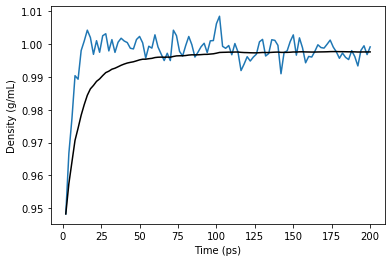

In [27]:
#data = pd.read_csv(f"scalars_{len(solutes)}solutes_N{n_solvent_mol}solvent.csv")
data = pd.read_csv('scalars_polymer_50units_N8000_size34.0x34.0x224_NPT.csv')
#print(data)
#print(data.head())
time = data['#"Time (ps)"']
V = data["Box Volume (nm^3)"]
rho = data["Density (g/mL)"]
plt.plot(time,rho)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/mL)')

total_value = 0
ma_data=[]
for idx,value in enumerate(rho):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')

#http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Acetonitrile
print(f"The average density at convergion is: {ma_data[-1]}")

plt.show()

In [ ]:
plt.plot(time,V)
plt.xlabel('Time (ps)')
plt.ylabel('Box Volume ($nm^3$)')
total_value = 0
ma_data=[]
for idx,value in enumerate(V):
    total_value += value
    ma_data.append(total_value/(idx+1))

ma_data = np.array(ma_data)
plt.plot(time,ma_data,'black')
print(f"The average volume at convergion is: {ma_data[-1]}")
#cube dimension in Angstrom
cube_dim = ((ma_data[-1]**(1/3))*nanometer/angstrom)
print(f"The box dimensions for a NVT simulation should hence be: {cube_dim}")
plt.show()